# Import Packages & Create Dataframe

In [1]:
#import packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from skopt import BayesSearchCV

In [2]:
#import behaviors file
behaviors = pd.read_csv(r"C:\Users\josia\Desktop\Capstone_Project\MINDlarge_train\behaviors.tsv", sep='\t')

In [3]:
#convert behavior data to dataframe
b_df = pd.DataFrame(behaviors)

# Examine Dataframe

In [4]:
b_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232747 entries, 0 to 2232746
Data columns (total 5 columns):
 #   Column                                                                                                                                                                     Dtype 
---  ------                                                                                                                                                                     ----- 
 0   1                                                                                                                                                                          int64 
 1   U87243                                                                                                                                                                     object
 2   11/10/2019 11:30:54 AM                                                                                                                                 

In [5]:
print(b_df.head())

   1   U87243  11/10/2019 11:30:54 AM  \
0  2  U598644   11/12/2019 1:45:29 PM   
1  3  U532401  11/13/2019 11:23:03 AM   
2  4  U593596  11/12/2019 12:24:09 PM   
3  5  U239687   11/14/2019 8:03:01 PM   
4  6  U521853  11/11/2019 10:47:31 AM   

  N8668 N39081 N65259 N79529 N73408 N43615 N29379 N32031 N110232 N101921 N12614 N129591 N105760 N60457 N1229 N64932  \
0  N56056 N8726 N70353 N67998 N83823 N111108 N107...                                                                  
1  N128643 N87446 N122948 N9375 N82348 N129412 N5...                                                                  
2  N31043 N39592 N4104 N8223 N114581 N92747 N1207...                                                                  
3  N65250 N122359 N71723 N53796 N41663 N41484 N11...                                                                  
4  N8668 N29136 N128643 N9740 N9375 N52911 N12090...                                                                  

  N78206-0 N26368-0 N7578-0 N58592-0 N

In [6]:
#Create column names based on dataset legend found elsewhere
b_column_names = ['Impression_ID', 'User_ID', 'Time', 'History', 'Impressions']
b_df.columns = b_column_names

# Take Sample of DataFrame

In [7]:
b_df = b_df.sample(n=5000, random_state=1)

# Data Legend & Next Steps

# Data Wrangling

In [8]:
#Drop 'Impression_ID' and 'Time' columns as they do not pertain to my use case
columns_to_drop = ['Impression_ID', 'Time']
b_df = b_df.drop(columns = columns_to_drop)
print(b_df.head())

         User_ID                                            History  \
1837023  U591810                                N91352 N4555 N88075   
1328700   U21881  N1128 N79529 N45491 N79909 N104091 N53933 N852...   
1645076   U71066  N81496 N116312 N20359 N29595 N104200 N57016 N3...   
2155197  U455452  N109183 N63078 N91173 N45756 N122766 N9979 N82...   
527583   U240645               N127644 N40915 N27226 N120031 N27763   

                                               Impressions  
1837023  N67123-0 N100343-0 N23823-0 N8719-0 N11682-0 N...  
1328700  N8599-0 N8236-0 N56873-0 N76665-0 N51163-0 N65...  
1645076       N53474-0 N5287-0 N113723-1 N24701-1 N76677-0  
2155197  N90184-0 N67937-0 N81374-0 N15403-1 N48015-0 N...  
527583   N96356-0 N73137-0 N52435-0 N31766-0 N118589-0 ...  


In [9]:
#Group data by User ID
b_df_g = b_df.sort_values(by = 'User_ID')

In [10]:
#Check for missing values
b_df_g_missing = b_df_g.isnull().sum()
print(b_df_g_missing)

User_ID         0
History        97
Impressions     0
dtype: int64


In [11]:
#Examine type of missing value
b_df_g_hist_miss = b_df_g['History'].isnull()

In [12]:
print(b_df_g_hist_miss)

746803     False
1007026    False
1788588    False
1044349    False
98296      False
           ...  
933641     False
1941382     True
785973     False
811970     False
1788046    False
Name: History, Length: 5000, dtype: bool


In [13]:
#Drop all rows with missing value
b_df_g_drop = b_df_g.dropna()
print(b_df_g_drop.isnull().sum())

User_ID        0
History        0
Impressions    0
dtype: int64


In [14]:
#Check to see how many remaining rows with data there are
print(b_df_g_drop.shape[0])

4903


In [15]:
#rename data frame
b_df = b_df_g_drop

In [16]:
b_df.dtypes

User_ID        object
History        object
Impressions    object
dtype: object

In [17]:
#group data by User_ID
grouped_df = b_df.groupby('User_ID').agg({
    'History': lambda x: ','.join(x),  # Combine all 'History' values into one string
    'Impressions': lambda x: ','.join(x)  # Combine all 'Impressions' values into one string
}).reset_index()

# Step 2: Remove duplicates within each combined string
grouped_df['History'] = grouped_df['History'].apply(lambda x: ','.join(set(x.split(','))))
grouped_df['Impressions'] = grouped_df['Impressions'].apply(lambda x: ','.join(set(x.split(','))))

print(grouped_df)

      User_ID                                            History  \
0     U100159                                             N59700   
1     U100179  N3682 N127175 N64765 N62551 N104760 N81982 N10...   
2     U100253  N94639 N104181 N6612 N86208 N1229 N10000 N6317...   
3     U100346  N90185 N61319 N15797 N65119 N94639 N52595 N769...   
4     U100367  N122359 N94953 N29786 N82261 N54723 N29786 N16...   
...       ...                                                ...   
4870   U99457  N110755 N92279 N62936 N63858 N34292 N60511 N42...   
4871   U99461  N50434 N98967 N91510 N23321 N14518 N33741 N229...   
4872   U99541  N9375 N101263 N105296 N34684 N19665 N105375 N1...   
4873   U99875  N9740 N17201 N37721 N18389 N2237 N32800 N98156...   
4874   U99920  N77001 N66535 N89872 N16078 N82799 N72571 N294...   

                                            Impressions  
0     N2750-0 N59301-0 N60135-0 N116647-0 N92498-1 N...  
1     N67927-0 N14848-1 N118589-0 N6293-0 N99362-0 N...  
2     N12

In [18]:
grouped_df.dtypes

User_ID        object
History        object
Impressions    object
dtype: object

In [19]:
# Function to add "-1" to each ID and join back with spaces
def add_suffix_to_ids(ids_string):
    ids_list = ids_string.split()  # Split the string of IDs into a list
    ids_list_with_suffix = [id + '-1' for id in ids_list]  # Add "-1" to each ID
    return ' '.join(ids_list_with_suffix)  # Join the modified IDs back with spaces

# Apply the function to the 'History' column
grouped_df['History'] = grouped_df['History'].apply(add_suffix_to_ids)

# Display the updated DataFrame
print(grouped_df)

      User_ID                                            History  \
0     U100159                                           N59700-1   
1     U100179  N3682-1 N127175-1 N64765-1 N62551-1 N104760-1 ...   
2     U100253  N94639-1 N104181-1 N6612-1 N86208-1 N1229-1 N1...   
3     U100346  N90185-1 N61319-1 N15797-1 N65119-1 N94639-1 N...   
4     U100367  N122359-1 N94953-1 N29786-1 N82261-1 N54723-1 ...   
...       ...                                                ...   
4870   U99457  N110755-1 N92279-1 N62936-1 N63858-1 N34292-1 ...   
4871   U99461  N50434-1 N98967-1 N91510-1 N23321-1 N14518-1 N...   
4872   U99541  N9375-1 N101263-1 N105296-1 N34684-1 N19665-1 ...   
4873   U99875  N9740-1 N17201-1 N37721-1 N18389-1 N2237-1 N32...   
4874   U99920  N77001-1 N66535-1 N89872-1 N16078-1 N82799-1 N...   

                                            Impressions  
0     N2750-0 N59301-0 N60135-0 N116647-0 N92498-1 N...  
1     N67927-0 N14848-1 N118589-0 N6293-0 N99362-0 N...  
2     N12

In [20]:
#combine the history and impressions columns together
def combine_history_impressions(row):
    history_list = row['History'].split()  # Split 'History' string into a list of IDs
    impressions_list = row['Impressions'].split()  # Split 'Impressions' string into a list of IDs
    combined_list = list(set(history_list + impressions_list))  # Combine and remove duplicates
    combined_string = ' '.join(combined_list)  # Join the combined list back into a string
    return combined_string

# Apply the function to create a new 'Combined' column
grouped_df['Combined'] = grouped_df.apply(combine_history_impressions, axis=1)

# Display the updated DataFrame
print(grouped_df)

      User_ID                                            History  \
0     U100159                                           N59700-1   
1     U100179  N3682-1 N127175-1 N64765-1 N62551-1 N104760-1 ...   
2     U100253  N94639-1 N104181-1 N6612-1 N86208-1 N1229-1 N1...   
3     U100346  N90185-1 N61319-1 N15797-1 N65119-1 N94639-1 N...   
4     U100367  N122359-1 N94953-1 N29786-1 N82261-1 N54723-1 ...   
...       ...                                                ...   
4870   U99457  N110755-1 N92279-1 N62936-1 N63858-1 N34292-1 ...   
4871   U99461  N50434-1 N98967-1 N91510-1 N23321-1 N14518-1 N...   
4872   U99541  N9375-1 N101263-1 N105296-1 N34684-1 N19665-1 ...   
4873   U99875  N9740-1 N17201-1 N37721-1 N18389-1 N2237-1 N32...   
4874   U99920  N77001-1 N66535-1 N89872-1 N16078-1 N82799-1 N...   

                                            Impressions  \
0     N2750-0 N59301-0 N60135-0 N116647-0 N92498-1 N...   
1     N67927-0 N14848-1 N118589-0 N6293-0 N99362-0 N...   
2     

In [21]:
#drop impressions and history columns
column_list = ['Impressions', 'History']
grouped_df.drop(columns = column_list, inplace=True)

In [22]:
print(grouped_df)

      User_ID                                           Combined
0     U100159  N92498-1 N18539-0 N48418-0 N115021-0 N60135-0 ...
1     U100179  N24642-1 N67927-0 N99362-0 N50148-1 N64765-1 N...
2     U100253  N93856-0 N94639-1 N97564-0 N106659-0 N23011-0 ...
3     U100346  N15797-1 N54393-1 N22225-0 N79480-0 N55792-0 N...
4     U100367  N66244-0 N25751-0 N100289-0 N43533-0 N22999-0 ...
...       ...                                                ...
4870   U99457  N70848-1 N57797-1 N91923-1 N60511-1 N23128-1 N...
4871   U99461  N92277-1 N70751-1 N62652-1 N21250-1 N13518-1 N...
4872   U99541  N76775-1 N93643-0 N47257-1 N105296-1 N21883-0 ...
4873   U99875  N2620-1 N111375-1 N81449-1 N50080-1 N9375-1 N1...
4874   U99920  N93856-0 N115743-1 N80823-1 N109498-1 N77001-1...

[4875 rows x 2 columns]


In [23]:
#renamed combined column
grouped_df.rename(columns={'Combined': 'Impressions'}, inplace=True)
print(grouped_df)

      User_ID                                        Impressions
0     U100159  N92498-1 N18539-0 N48418-0 N115021-0 N60135-0 ...
1     U100179  N24642-1 N67927-0 N99362-0 N50148-1 N64765-1 N...
2     U100253  N93856-0 N94639-1 N97564-0 N106659-0 N23011-0 ...
3     U100346  N15797-1 N54393-1 N22225-0 N79480-0 N55792-0 N...
4     U100367  N66244-0 N25751-0 N100289-0 N43533-0 N22999-0 ...
...       ...                                                ...
4870   U99457  N70848-1 N57797-1 N91923-1 N60511-1 N23128-1 N...
4871   U99461  N92277-1 N70751-1 N62652-1 N21250-1 N13518-1 N...
4872   U99541  N76775-1 N93643-0 N47257-1 N105296-1 N21883-0 ...
4873   U99875  N2620-1 N111375-1 N81449-1 N50080-1 N9375-1 N1...
4874   U99920  N93856-0 N115743-1 N80823-1 N109498-1 N77001-1...

[4875 rows x 2 columns]


In [24]:
#rename df back to b_df
b_df = grouped_df

In [25]:
#Check for missing values
b_df.isnull().sum()

User_ID        0
Impressions    0
dtype: int64

In [26]:
#Check for duplicates
b_df.duplicated().sum()

0

In [27]:
#reassign dataframe
b_df_final = b_df

# Define batch size
batch_size = 1000  # Adjust according to memory constraints

# Process DataFrame in chunks
chunks = [b_df_final[i:i+batch_size] for i in range(0, len(b_df_final), batch_size)]
expanded_dfs = []

for chunk in chunks:
    expanded_df = chunk.assign(Impression_ID=chunk['Impressions'].str.split()).explode('Impression_ID')
    expanded_df.rename(columns={'User_ID': 'User_ID', 'Impression_ID': 'Impression_ID'}, inplace=True)
    expanded_dfs.append(expanded_df)

# Concatenate all expanded DataFrames
b_df_final = pd.concat(expanded_dfs, ignore_index=True)

print(b_df_final)


        User_ID                                        Impressions  \
0       U100159  N92498-1 N18539-0 N48418-0 N115021-0 N60135-0 ...   
1       U100159  N92498-1 N18539-0 N48418-0 N115021-0 N60135-0 ...   
2       U100159  N92498-1 N18539-0 N48418-0 N115021-0 N60135-0 ...   
3       U100159  N92498-1 N18539-0 N48418-0 N115021-0 N60135-0 ...   
4       U100159  N92498-1 N18539-0 N48418-0 N115021-0 N60135-0 ...   
...         ...                                                ...   
346658   U99920  N93856-0 N115743-1 N80823-1 N109498-1 N77001-1...   
346659   U99920  N93856-0 N115743-1 N80823-1 N109498-1 N77001-1...   
346660   U99920  N93856-0 N115743-1 N80823-1 N109498-1 N77001-1...   
346661   U99920  N93856-0 N115743-1 N80823-1 N109498-1 N77001-1...   
346662   U99920  N93856-0 N115743-1 N80823-1 N109498-1 N77001-1...   

       Impression_ID  
0           N92498-1  
1           N18539-0  
2           N48418-0  
3          N115021-0  
4           N60135-0  
...              ... 

In [28]:
b_df_final.drop(['Impressions'], axis=1, inplace = True)

In [29]:
print(b_df_final)

        User_ID Impression_ID
0       U100159      N92498-1
1       U100159      N18539-0
2       U100159      N48418-0
3       U100159     N115021-0
4       U100159      N60135-0
...         ...           ...
346658   U99920      N58200-1
346659   U99920      N46415-0
346660   U99920      N68429-1
346661   U99920      N75220-1
346662   U99920      N67497-1

[346663 rows x 2 columns]


In [30]:
b_df_final.head(10000).tail()

,User_ID,Impression_ID
9995,U116179,N40040-1
9996,U116179,N880-0
9997,U116179,N26097-1
9998,U116179,N34971-0
9999,U116179,N41547-0


In [31]:
b_df_final['Interaction'] = b_df_final['Impression_ID'].str[-1]

In [32]:
print(b_df_final)

        User_ID Impression_ID Interaction
0       U100159      N92498-1           1
1       U100159      N18539-0           0
2       U100159      N48418-0           0
3       U100159     N115021-0           0
4       U100159      N60135-0           0
...         ...           ...         ...
346658   U99920      N58200-1           1
346659   U99920      N46415-0           0
346660   U99920      N68429-1           1
346661   U99920      N75220-1           1
346662   U99920      N67497-1           1

[346663 rows x 3 columns]


In [33]:
b_df_final['Article_ID'] = b_df_final['Impression_ID'].str[:-2]

In [34]:
print(b_df_final)

        User_ID Impression_ID Interaction Article_ID
0       U100159      N92498-1           1     N92498
1       U100159      N18539-0           0     N18539
2       U100159      N48418-0           0     N48418
3       U100159     N115021-0           0    N115021
4       U100159      N60135-0           0     N60135
...         ...           ...         ...        ...
346658   U99920      N58200-1           1     N58200
346659   U99920      N46415-0           0     N46415
346660   U99920      N68429-1           1     N68429
346661   U99920      N75220-1           1     N75220
346662   U99920      N67497-1           1     N67497

[346663 rows x 4 columns]


In [35]:
b_df_final.drop(columns = ['Impression_ID'])

,User_ID,Interaction,Article_ID
0,U100159,1,N92498
1,U100159,0,N18539
2,U100159,0,N48418
3,U100159,0,N115021
4,U100159,0,N60135
...,...,...,...
346658,U99920,1,N58200
346659,U99920,0,N46415
346660,U99920,1,N68429
346661,U99920,1,N75220


In [36]:
new_order = ['User_ID', 'Article_ID', 'Interaction']

# Reorder the DataFrame columns
b_df_final = b_df_final[new_order]

print(b_df_final)

        User_ID Article_ID Interaction
0       U100159     N92498           1
1       U100159     N18539           0
2       U100159     N48418           0
3       U100159    N115021           0
4       U100159     N60135           0
...         ...        ...         ...
346658   U99920     N58200           1
346659   U99920     N46415           0
346660   U99920     N68429           1
346661   U99920     N75220           1
346662   U99920     N67497           1

[346663 rows x 3 columns]


# Convert User_ID and Article ID to numeric values

In [37]:
b_df_final['Article_ID'] = b_df_final['Article_ID'].str.lstrip('N')
b_df_final['User_ID'] = b_df_final['User_ID'].str.lstrip('U')
print(b_df_final)

       User_ID Article_ID Interaction
0       100159      92498           1
1       100159      18539           0
2       100159      48418           0
3       100159     115021           0
4       100159      60135           0
...        ...        ...         ...
346658   99920      58200           1
346659   99920      46415           0
346660   99920      68429           1
346661   99920      75220           1
346662   99920      67497           1

[346663 rows x 3 columns]


In [38]:
#check for errors
mask = b_df_final['Article_ID'].str.len() > 6
filtered_df = b_df_final[mask]
print(filtered_df)

       User_ID        Article_ID Interaction
2193    103661   103852-0,N54223           1
69055   226614   100073-0,N98178           0
93414   273939    77870-0,N74682           1
95497   277582     66929-0,N8719           0
108314  300975    43729-0,N38903           0
111332  307172   114135-0,N71090           0
114601  311989   81297-0,N111291           1
136676  355302    56339-0,N18553           0
140146  360251   108645-0,N41710           0
142047   36481     55831-0,N5287           0
143681   36745    46716-0,N60032           0
154302  388946  100539-0,N102458           0
154568  389137    2624-0,N102846           0
166582    4099  112156-0,N112156           0
174888  425855    125642-0,N5032           0
182174   43887    40064-0,N58641           0
182700  439196    85877-0,N41710           0
188001  447636    67264-0,N10646           0
191589  454695    91865-0,N91865           0
206701  482778    63827-0,N37441           0
231431  529783   111291-0,N26368           0
239815  54

In [39]:
b_df_final = b_df_final.drop(38177)

In [40]:
print(b_df_final)

       User_ID Article_ID Interaction
0       100159      92498           1
1       100159      18539           0
2       100159      48418           0
3       100159     115021           0
4       100159      60135           0
...        ...        ...         ...
346658   99920      58200           1
346659   99920      46415           0
346660   99920      68429           1
346661   99920      75220           1
346662   99920      67497           1

[346662 rows x 3 columns]


In [41]:
# Convert columns to numeric
b_df_final['User_ID'] = pd.to_numeric(b_df_final['User_ID'], errors='coerce')
b_df_final['Article_ID'] = pd.to_numeric(b_df_final['Article_ID'], errors='coerce')
b_df_final['Interaction'] = pd.to_numeric(b_df_final['Interaction'], errors='coerce')

In [42]:
b_df_final.isnull().sum()

User_ID         0
Article_ID     28
Interaction     0
dtype: int64

In [43]:
b_df_final = b_df_final.dropna()

In [44]:
print(b_df_final.shape)

(346634, 3)


In [45]:
print(b_df_final)
b_df_final.dtypes

        User_ID  Article_ID  Interaction
0        100159     92498.0            1
1        100159     18539.0            0
2        100159     48418.0            0
3        100159    115021.0            0
4        100159     60135.0            0
...         ...         ...          ...
346658    99920     58200.0            1
346659    99920     46415.0            0
346660    99920     68429.0            1
346661    99920     75220.0            1
346662    99920     67497.0            1

[346634 rows x 3 columns]


User_ID          int64
Article_ID     float64
Interaction      int64
dtype: object

In [46]:
df = b_df_final

# Exploratory Data Analysis

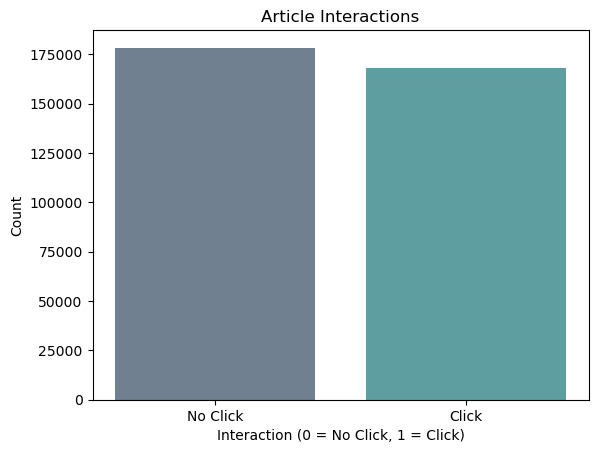

In [47]:
import matplotlib.pyplot as plt
counts = df['Interaction'].value_counts()

plt.bar(counts.index, counts.values, color=['slategrey', 'cadetblue'])
plt.xlabel('Interaction (0 = No Click, 1 = Click)')
plt.ylabel('Count')
plt.title('Article Interactions')

plt.xticks([0, 1], ['No Click', 'Click'])  
plt.show()

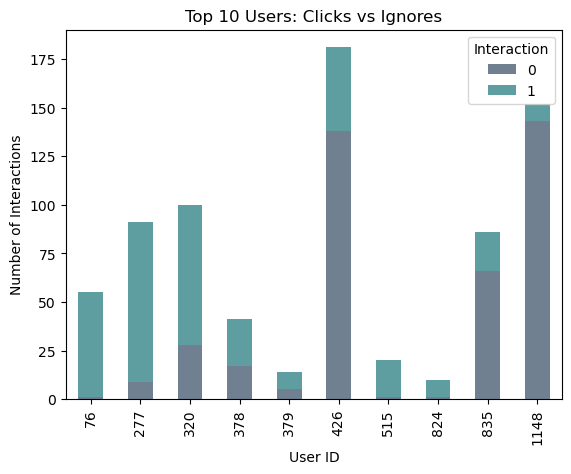

In [48]:
user_interactions = df.groupby(['User_ID', 'Interaction']).size().unstack(fill_value=0)
user_interactions.head(10).plot(kind='bar', stacked=True, color=['slategrey', 'cadetblue'])
plt.title('Top 10 Users: Clicks vs Ignores')
plt.xlabel('User ID')
plt.ylabel('Number of Interactions')
plt.show()

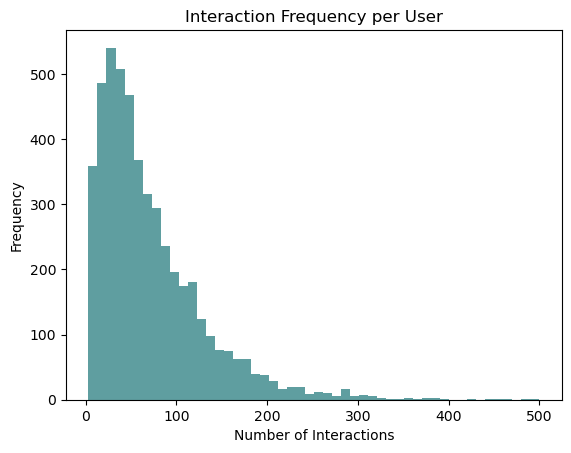

In [49]:
df['User_ID'].value_counts().plot(kind='hist', bins=50, color='cadetblue')
plt.title('Interaction Frequency per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()

In [50]:
interaction_counts = df['User_ID'].value_counts()

# Calculate mean
mean_interactions = interaction_counts.mean()

# Calculate median
median_interactions = interaction_counts.median()

print(mean_interactions)
print(median_interactions)

71.10441025641026
54.0


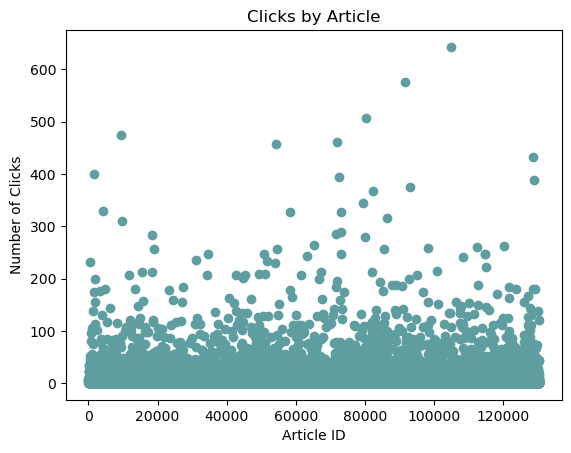

In [51]:
click_data = df[df['Interaction'] == 1]
article_clicks = click_data['Article_ID'].value_counts()
plt.scatter(article_clicks.index, article_clicks.values, color = 'cadetblue')
plt.title('Clicks by Article')
plt.xlabel('Article ID')
plt.ylabel('Number of Clicks')
plt.show()

In [52]:
article_clicks.mean()

8.867647058823529

# Model Building & Evaluation

In [53]:
# Features (User_ID and Article_ID) and Target (Interaction)
X = df[['User_ID', 'Article_ID']]
y = df[['Interaction']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model

In [54]:
# Train logistic regression on known interactions (0s and 1s)
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

C:\Users\josia\anaconda3\Desktop\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.5145758506786677
Precision: 0.5010508289873122
Recall: 0.19112232779097388
F1 Score: 0.27669955079846115


# XG Boost Classifier 

In [55]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Mean Squared Error: {mse:.2f}')

C:\Users\josia\anaconda3\Desktop\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.62
Precision: 0.62
Recall: 0.56
F1 Score: 0.59
Mean Squared Error: 0.38


# Random Forest Classifier Model:

In [56]:
# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define the search space for hyperparameters
search_space = {
    'n_estimators': (100, 300),  # Example range for number of trees
    'max_depth': (5, 50),         # Example range for maximum depth
    'min_samples_leaf': (1, 10),  # Example range for minimum samples per leaf
    'min_samples_split': (2, 20)   # Example range for minimum samples to split
}

# Initialize Bayesian Optimization
bayes_search = BayesSearchCV(
    rf_model,
    search_space,
    n_iter=30,                     # Number of iterations
    scoring='f1',                  # Metric to optimize
    cv=5,                          # Cross-validation
    n_jobs=-1,                     # Use all available cores
    random_state=42
)

# Fit the model to the training data
bayes_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

# Print the results
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Make predictions on the test set using the best model
y_pred = bayes_search.predict(X_test)

# Evaluate the model performance
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')

C:\Users\josia\anaconda3\Desktop\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: OrderedDict([('max_depth', 47), ('min_samples_leaf', 1), ('min_samples_split', 14), ('n_estimators', 300)])
Best Cross-Validation Score: 0.7847431784005717
Accuracy: 0.8056168592323337
Precision: 0.8180930789092512
Recall: 0.7714073634204276
F1 Score: 0.794064610776613
ROC AUC Score: 0.8046730199434452


In [59]:
# Initialize and train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=47, min_samples_leaf=1, min_samples_split=14)
rf_model.fit(X_train, y_train)

C:\Users\josia\anaconda3\Desktop\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=47, min_samples_split=14, n_estimators=300,
                       random_state=42)

# Model Comparison

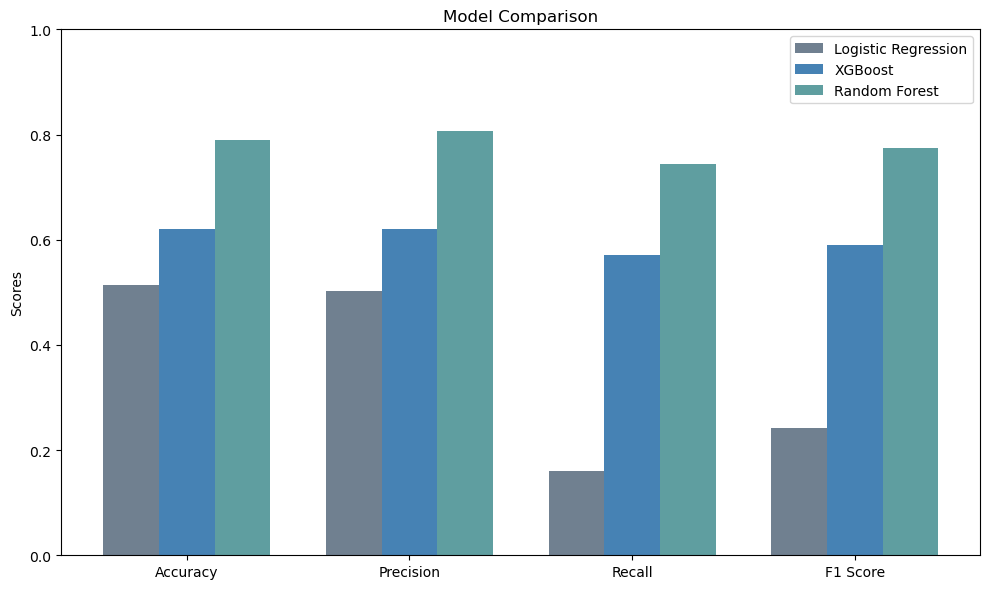

In [60]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
logistic_regression = [0.5132, 0.5017, 0.1601, 0.2427]
xgboost = [0.62, 0.62, 0.57, 0.59]
random_forest = [0.7894, 0.8073, 0.7448, 0.7748]

x = np.arange(len(metrics))
width = 0.25  

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, logistic_regression, width, label='Logistic Regression', color='slategrey')
rects2 = ax.bar(x, xgboost, width, label='XGBoost', color='steelblue')
rects3 = ax.bar(x + width, random_forest, width, label='Random Forest', color='cadetblue')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

# Algorithm Recommendations

In [61]:
predicted_probabilities = rf_model.predict_proba(X_test)
print(predicted_probabilities)

[[0.3681743  0.6318257 ]
 [0.04903578 0.95096422]
 [0.68234456 0.31765544]
 ...
 [0.53400297 0.46599703]
 [0.70773848 0.29226152]
 [0.30002254 0.69997746]]


In [62]:
# Create a DataFrame to hold the probabilities and their corresponding User_ID and Article_ID
recommendations = pd.DataFrame(predicted_probabilities, columns=['Prob_No_Interaction', 'Prob_Interaction'])
recommendations['User_ID'] = X_test['User_ID'].values
recommendations['Article_ID'] = X_test['Article_ID'].values

def categorize_interaction(row):
    if row['Prob_Interaction'] >= 0.75:
        return 'Most Likely to Interact'
    else:
        return 'Unlikely to Interact'

recommendations['Recommendation_Category'] = recommendations.apply(categorize_interaction, axis=1)

most_likely = recommendations[recommendations['Recommendation_Category'] == 'Most Likely to Interact']
least_likely = recommendations[recommendations['Recommendation_Category'] == 'Unlikely to Interact'] 

print("Most Likely to Interact Articles:")
print(most_likely[['User_ID', 'Article_ID', 'Prob_Interaction']])

print("\nUnlikely to Interact Articles:")
print(least_likely[['User_ID', 'Article_ID', 'Prob_Interaction']])


Most Likely to Interact Articles:
       User_ID  Article_ID  Prob_Interaction
1        16311     50676.0          0.950964
13      578952    121133.0          0.853814
14      165916     72105.0          0.780037
37      604330     58200.0          0.962295
43      226464     50645.0          0.878159
...        ...         ...               ...
69309   657687     49965.0          0.782357
69313   597961    119800.0          0.792797
69314   546120     58200.0          0.960345
69318   658766    104312.0          0.869887
69320   512810     66666.0          0.767771

[11246 rows x 3 columns]

Unlikely to Interact Articles:
       User_ID  Article_ID  Prob_Interaction
0       172650     60001.0          0.631826
2       197923     91047.0          0.317655
3       232937     29866.0          0.713950
4       252182     55903.0          0.524933
5        33479    118266.0          0.284588
...        ...         ...               ...
69322   201131     41658.0          0.474930
69323   

In [63]:
N = 10  

num_most_likely = int(0.50 * N)
num_least_likely = int(0.50 * N)

# Ensure we have enough data in each category (this step is important for smaller datasets)
def recommend_for_user(user_id, user_recommendations):
    # Filter for the given user
    user_most_likely = user_recommendations[user_recommendations['User_ID'] == user_id]
    
    # Separate by category
    most_likely_articles = user_most_likely[user_most_likely['Recommendation_Category'] == 'Most Likely to Interact']
    neutral_articles = user_most_likely[user_most_likely['Recommendation_Category'] == 'Neutral to Interact']
    least_likely_articles = user_most_likely[user_most_likely['Recommendation_Category'] == 'Unlikely to Interact']
    
    # Randomly sample from each category
    most_likely_sampled = most_likely_articles.sample(n=min(num_most_likely, len(most_likely_articles)), random_state=42)
    least_likely_sampled = least_likely_articles.sample(n=min(num_least_likely, len(least_likely_articles)), random_state=42)
    
    # Combine the samples
    final_recommendations = pd.concat([most_likely_sampled, least_likely_sampled])
    
    return final_recommendations

# Apply the recommendation logic to all users in the test set
all_user_ids = recommendations['User_ID'].unique()

final_recommendations_df = pd.DataFrame()

for user_id in all_user_ids:
    user_recommendations = recommend_for_user(user_id, recommendations)
    final_recommendations_df = pd.concat([final_recommendations_df, user_recommendations])

print(final_recommendations_df[['User_ID', 'Article_ID', 'Recommendation_Category']])

       User_ID  Article_ID  Recommendation_Category
14353   172650    122762.0  Most Likely to Interact
59728   172650     91649.0  Most Likely to Interact
7003    172650     88769.0  Most Likely to Interact
16363   172650     12324.0  Most Likely to Interact
0       172650     60001.0     Unlikely to Interact
...        ...         ...                      ...
67963   576299    103852.0     Unlikely to Interact
67976   139059     55792.0     Unlikely to Interact
68075   614505     90968.0     Unlikely to Interact
68691   572166     53474.0     Unlikely to Interact
69024   336254     96539.0     Unlikely to Interact

[28823 rows x 3 columns]


In [69]:
print(final_recommendations_df.head(9))

       Prob_No_Interaction  Prob_Interaction  User_ID  Article_ID  \
14353             0.185858          0.814142   172650    122762.0   
59728             0.053135          0.946865   172650     91649.0   
7003              0.062283          0.937717   172650     88769.0   
16363             0.225841          0.774159   172650     12324.0   
0                 0.368174          0.631826   172650     60001.0   
2840              0.437187          0.562813   172650     27828.0   
14523             0.492540          0.507460   172650     69936.0   
39878             0.347720          0.652280   172650     44185.0   
37816             0.374543          0.625457   172650     45931.0   

       Recommendation_Category  
14353  Most Likely to Interact  
59728  Most Likely to Interact  
7003   Most Likely to Interact  
16363  Most Likely to Interact  
0         Unlikely to Interact  
2840      Unlikely to Interact  
14523     Unlikely to Interact  
39878     Unlikely to Interact  
37816     Un